In [1]:
from importlib.metadata import files
from pathlib import Path
import os

import requests
import pandas as pd
import numpy as np
import csv
from typing import List

import matplotlib
import matplotlib.pyplot as plt
# plt.ion()

In [2]:
def read_tbl_into_strings(path: Path) -> List[str]:
    """
    Reads a .tbl file (or any text file) and returns a list of strings,
    one per row (line), without the trailing newline.
    """
    lines: List[str] = []
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            # strip only the newline; preserve any other whitespace
            lines.append(line.rstrip('\n'))
    return lines

In [3]:
def form_syscall_dict() -> dict:
    file_path = Path("syscall_64.tbl")

    if not file_path.exists() or not file_path.is_file():
        raw_url = "https://raw.githubusercontent.com/torvalds/linux/refs/heads/master/arch/x86/entry/syscalls/syscall_64.tbl"
        dest = "./syscall_64.tbl"
        dest = Path(dest)

        resp = requests.get(raw_url)
        resp.raise_for_status()  # will raise HTTPError for bad status
        dest.parent.mkdir(parents=True, exist_ok=True)
        dest.write_bytes(resp.content)
        print(f"Downloaded {raw_url!r} → {dest}")

    tbl_path = Path('syscall_64.tbl')
    rows_as_strings = read_tbl_into_strings(tbl_path)

    filtered = [s for s in rows_as_strings
                if s.strip() and not s.lstrip().startswith('#')]
    filtered = [s for s in filtered if "x32" not in s]

    syscall_dict = {}

    for row in filtered:
        parts = row.split()
        if len(parts) >= 4:
            syscall_dict[parts[3]] = int(parts[0])

        elif len(parts) == 3:
            syscall_dict[parts[2]] = int(parts[0])

        else:
            raise ValueError(f"Invalid syscall {row}")

    return syscall_dict

In [64]:
def write_out_syscalls(syscall_dict: dict, syscall_lines: list) -> None:
    filtered = [s.replace("_enter_", "_") for s in syscall_lines if "_exit_" not in s]
    filtered = [s for s in filtered if "monitor_syscall" not in s]
    filtered = [s for s in filtered if "trace-cmd" not in s]

    syscall_ints = []
    syscall_time = []

    for row in filtered:
        parts = row.split()

        syscall_text = parts[3][:-1]
        syscall_ts = parts[2][:-1]
        # print(syscall_ts)
        try:
            syscall_ints.append(syscall_dict[syscall_text])
            syscall_time.append(float(syscall_ts))
        except KeyError:
            substr = "sys_"
            index, first = next(((i,s) for i,s in enumerate(parts) if substr in s), (None,None))

            if first:
                first = first[:-1]
                ts = parts[index-1][:-1]
                # if first == '112882.623291':
                #     print("hi")

                syscall_ints.append(syscall_dict[first])
                syscall_time.append(float(ts))

            else:
                print(f"Invalid syscall {row}")
                continue
                # raise ValueError(f"Invalid syscall: {row}")


    with open(output_file_path, 'w', encoding='utf-8') as f:
        f.write(" ".join(map(str, syscall_ints))+"\n")
        f.write(" ".join(map(str, syscall_time)))

    return

In [114]:
TRANSLATE_SYSCALL_FILES = True

output_dir = "../outputs/"

if TRANSLATE_SYSCALL_FILES:
    syscall_dict = form_syscall_dict()

    for base_file in os.listdir(output_dir):
        if "_ints.txt" not in base_file:
            input_file_path = Path(output_dir + base_file)
            output_file_path = Path(output_dir + base_file + "_ints.txt")
            if os.path.exists(output_file_path) and (os.path.getmtime(output_file_path) > os.path.getmtime(input_file_path)):
                continue
        else:
            continue
        print(base_file)
        syscall_lines = read_tbl_into_strings(input_file_path)
        target = "cpus=32"
        idx = next((i for i, s in enumerate(syscall_lines) if s == target), None) + 1
        syscall_lines = syscall_lines[idx:]
        write_out_syscalls(syscall_dict, syscall_lines)


AES_O_exfil_awsi1_system_timed
AES_O_exfil_awsi2_system_timed
AES_O_exfil_none_system_timed
AES_O_exfil_sftp1_system_timed
AES_O_exfil_sftp2_system_timed
idle_20_trace_system_timed
AES_O_exfil_aws2_system_timed
AES_O_exfil_aws1_system_timed


In [115]:
import io

cwd = Path.cwd()
file_list = [
    output_dir+"idle_20_trace_system_timed_ints.txt",
    output_dir+"AES_O_exfil_none_system_timed_ints.txt",
    output_dir+"AES_O_exfil_sftp2_system_timed_ints.txt",
    # output_dir+"AES_WB_exfil_none_comb_system_ints.txt",
]


trace_list = []
time_list = []

for file in file_list:
    # file_path = cwd / file

    with open(file, "r", newline="") as f:
        lines = f.readlines()
        arr1 = np.loadtxt(io.StringIO(lines[0]), dtype=int)
        arr2 = np.loadtxt(io.StringIO(lines[1]), dtype=float)
        trace_list.append(arr1)
        time_list.append(arr2)

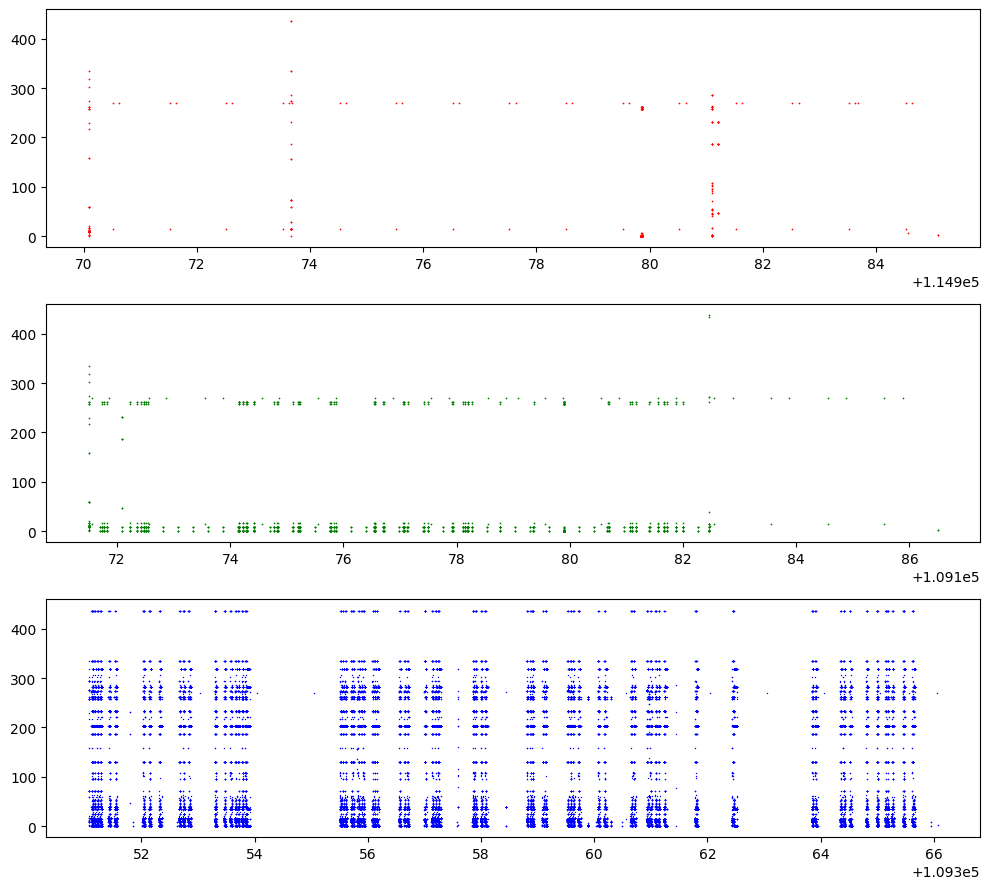

In [116]:
fig, ax = plt.subplots(3, 1, figsize=(10, 9), sharey=True)
ax[0].plot(time_list[0], trace_list[0], color="red", marker='.', linestyle="None", markersize=2.5, markeredgecolor='none')
ax[1].plot(time_list[1], trace_list[1], color="green", marker='.', linestyle="None", markersize=2.5, markeredgecolor='none')
ax[2].plot(time_list[2], trace_list[2], color="blue", marker='.', linestyle="None", markersize=2, markeredgecolor='none')
# ax[2].set_ylim((400,500))
plt.tight_layout()
plt.show()

In [67]:
output_dir = "../outputs/"

syscall_map = []

for base_file in os.listdir(output_dir):
    if "_ints.txt" not in base_file:
        continue
    print(base_file)
    input_file_path = Path(output_dir + base_file)
    with open(input_file_path, "r") as f:
        line = f.readlines()[1]
        print(line.split()[1:10])
    break
        # for val in line.split():
#             if int(val) not in syscall_map:
#                 syscall_map.append(int(val))
# print(sorted(syscall_map))

AES_WA_exfil_aws_comb_system2_ints.txt
['117298.030661', '117298.030665', '117298.030667', '117298.030667', '117298.030669', '117298.030671', '117298.030672', '117298.030676', '117298.030677']
